In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras import models

In [6]:
train_folder = './dataset/train'

# Specify the image size and batch size
img_size = (224, 224)
batch_size = 32

# Use data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)

# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Specify training set
)

validation_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Specify validation set
)

Found 4576 images belonging to 8 classes.
Found 1136 images belonging to 8 classes.


In [3]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a custom model for activity recognition
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

58889256/58889256 [==============================] - 83s 1us/step


In [4]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 21139528 (80.64 MB)
Trainable params: 6424840 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [5]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    verbose=1
)

Epoch 1/10
143/143 [==============================] - 1430s 10s/step - loss: 1.8141 - accuracy: 0.3684 - val_loss: 1.1836 - val_accuracy: 0.6527
Epoch 2/10
143/143 [==============================] - 1373s 10s/step - loss: 1.3374 - accuracy: 0.4821 - val_loss: 1.0149 - val_accuracy: 0.6652
Epoch 3/10
143/143 [==============================] - 1370s 10s/step - loss: 1.2598 - accuracy: 0.5199 - val_loss: 0.9174 - val_accuracy: 0.6911
Epoch 4/10
143/143 [==============================] - 1392s 10s/step - loss: 1.1834 - accuracy: 0.5345 - val_loss: 0.9572 - val_accuracy: 0.7143
Epoch 5/10
143/143 [==============================] - 1398s 10s/step - loss: 1.1684 - accuracy: 0.5354 - val_loss: 0.9240 - val_accuracy: 0.7089
Epoch 6/10
143/143 [==============================] - 1366s 10s/step - loss: 1.1331 - accuracy: 0.5605 - val_loss: 0.8661 - val_accuracy: 0.7161
Epoch 7/10
143/143 [==============================] - 1426s 10s/step - loss: 1.1099 - accuracy: 0.5710 - val_loss: 0.8670 - val_ac

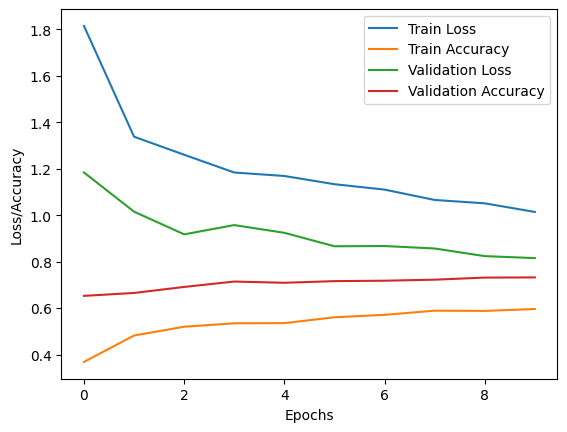

In [6]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [8]:
# Save the model in HDF5 format
model.save('har_model.keras')

In [3]:
# Load the trained model
loaded_model = models.load_model('har_model.keras')

1/1 [==============================] - 1s 815ms/step


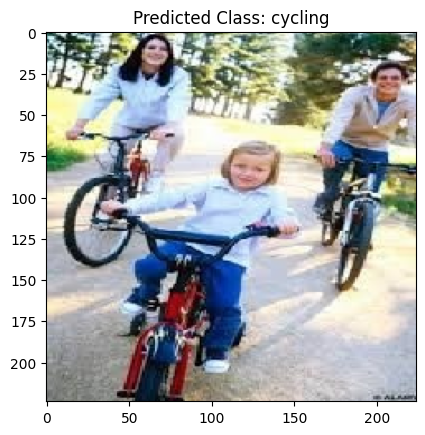

In [9]:
new_image_path = './dataset/test/cycling/Image_10783.jpg'  

# Load and preprocess the new image
img = load_img(new_image_path, target_size=(224, 224))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

# Make predictions
predictions = loaded_model.predict(img_array)

# Decode predictions
class_indices = train_generator.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}
predicted_class = inv_class_indices[np.argmax(predictions)]

# Display the new image and predicted class
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

In [10]:
train_generator.class_indices

{'cycling': 0,
 'dancing': 1,
 'eating': 2,
 'laughing': 3,
 'listening_to_music': 4,
 'running': 5,
 'sleeping': 6,
 'using_laptop': 7}

Found 1008 images belonging to 8 classes.


C:\Users\user\AppData\Local\Temp\ipykernel_5344\2318871925.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_generator)


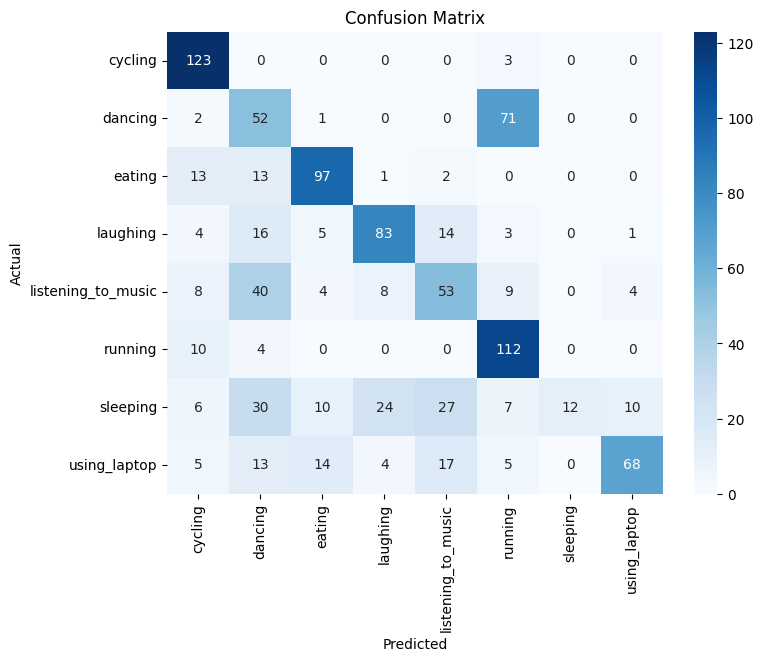

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

model = load_model('har_model.h5')

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
batch_size = 32 

test_generator = test_data_generator.flow_from_directory('./dataset/test/',
                                                         target_size=(224, 224),
                                                         batch_size=batch_size,
                                                         class_mode='categorical',
                                                         shuffle=False)

test_labels = test_generator.classes

predictions = model.predict_generator(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(test_labels, predicted_classes)

class_names = list(test_generator.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

